In [ ]:
## ONLY run this cell if you're in an NCI ARE notebook environment.
## Jupyter in the ARE notebook environment will always set the home
## directory as the current working directory (CWD), which will affect
## Python's import path. The following code fixes the import path by 
## changing the CWD into the notebook directory.
## Note that nci_ipynb only works for NCI ARE notebook environment.
## Project page: https://pypi.org/project/nci-ipynb
import nci_ipynb
os.chdir(nci_ipynb.dir())
print(os.getcwd())

Workflow Overview
=================

In essence, deep learning workflow consists of two stages - training and inference. Training refers to optimize model parameters given observational data. Inference refers to making model predictions given fixed model parameters and model inputs.

Training
--------

Training in deep learning involves solving the following optimization problem:

![title](assets/empirical_risk_minimization.png)

where

* data loader: loading the observation data. X is model input and Y is the target.

* model: a parametric model such as a neural network.

* loss function: measuring the difference between model predictions and the target y.

* optimizer: minimizing the loss function w.r.t model parameters.

* training loop: iteratively solves the minimization problem.

The following sections will demonstrate the minimum code that implements the above components in PyToch. This demonstration employs a tiny FourCastNeXt model with only a single layer. There is only a single training sample (i.e. N = 1). The training loop has a maximum steps of 200. FourCastNeXt is known for fast convergence. FourCastNeXt is publicly available: [github.com/nci/FourCastNeXt](https://github.com/nci/FourCastNeXt)

In [ ]:
import numpy as np
import xarray as xr
from datetime import datetime
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from model.simple_afnonet import AFNONet

In [4]:
## We seed the random number generator (RNG) for result reproducibility
torch.manual_seed(0)
np.random.seed(0)

## Set up the device the model will be trained on
## where 'cuda:0' means GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## data loader
inputs = torch.from_numpy(np.load('data/sample_inputs.npy')).to(device=device)
targets = torch.from_numpy(np.load('data/sample_targets.npy')).to(device=device)

## FourCastNeXt model
net = AFNONet().to(device)

## optimizer
max_steps = 200
learning_rate = 3e-3

optimizer = Adam(net.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, max_steps, eta_min=learning_rate*0.1)

## training loop
for step in range(max_steps):
    pred = net(inputs)
    
    ## loss function
    loss = F.mse_loss(pred, targets)

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    if step == 0 or (step+1) % 5 == 0 or step+1 == max_steps:
        epoch_time = datetime.now()
        loss_val = loss.item()
        print(f'step={step+1}/{max_steps}, loss={loss_val:.5f}, time={epoch_time}')

step=1/200, loss=0.02930, time=2023-11-06 18:14:01.209774
step=5/200, loss=0.88115, time=2023-11-06 18:14:06.836197
step=10/200, loss=0.33412, time=2023-11-06 18:14:13.139418
step=15/200, loss=0.16495, time=2023-11-06 18:14:19.183679
step=20/200, loss=0.11582, time=2023-11-06 18:14:25.197805
step=25/200, loss=0.07230, time=2023-11-06 18:14:31.277030
step=30/200, loss=0.05431, time=2023-11-06 18:14:37.245159
step=35/200, loss=0.04043, time=2023-11-06 18:14:43.462974
step=40/200, loss=0.02886, time=2023-11-06 18:14:49.322239
step=45/200, loss=0.02216, time=2023-11-06 18:14:55.177089
step=50/200, loss=0.01882, time=2023-11-06 18:15:01.024213
step=55/200, loss=0.01479, time=2023-11-06 18:15:06.649171
step=60/200, loss=0.01113, time=2023-11-06 18:15:12.383818
step=65/200, loss=0.00904, time=2023-11-06 18:15:18.338278
step=70/200, loss=0.00767, time=2023-11-06 18:15:24.063828
step=75/200, loss=0.00683, time=2023-11-06 18:15:30.071969
step=80/200, loss=0.00613, time=2023-11-06 18:15:35.749543

Training result
---------------

After the training, let's plot the model prediction and the ground truth for a comparison.
The left plot is the ground truth and the right plot is the model prediction. Training deep learning models is an iterative development process. One monitors the training loss values as well as the following plots to get an idea how the model performs.
For example, how do I know the learning rate should set to 3e-3? I tried a few different values and this one happens to give lowest training loss and best visual plots.

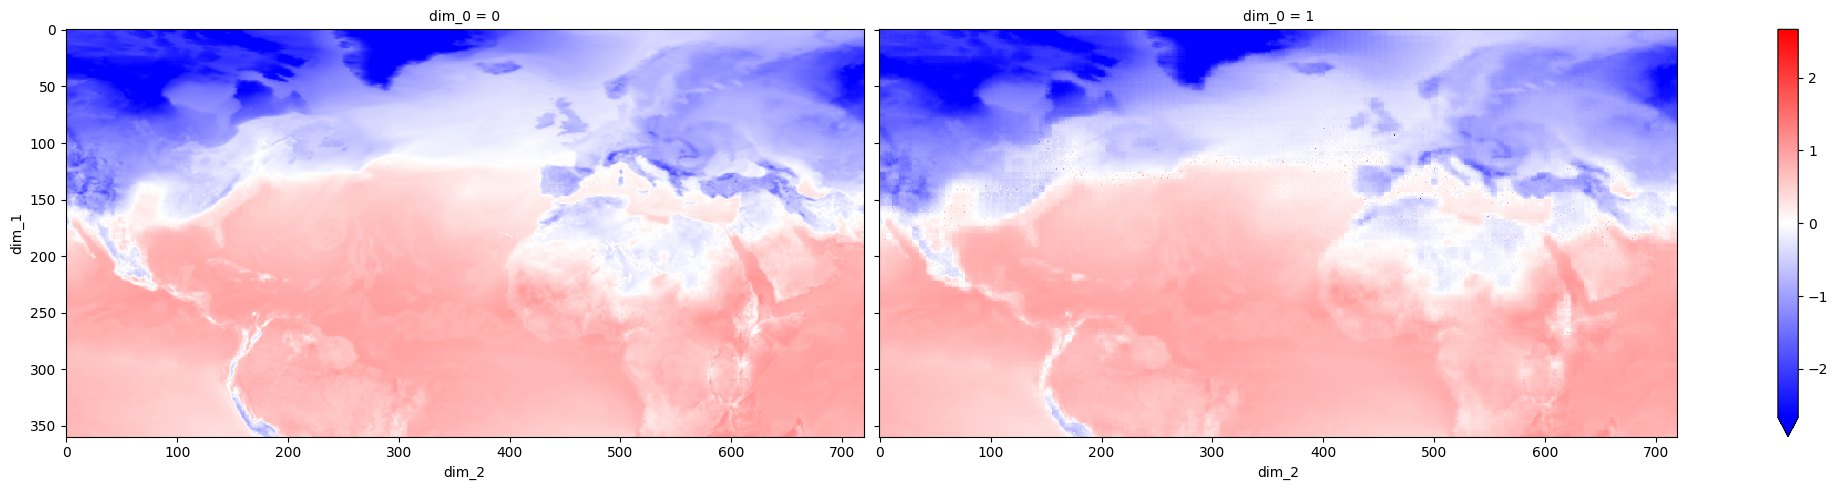

In [5]:
ground_truth = targets.cpu().numpy()[0]
prediction = net(inputs).detach().cpu().numpy()[0]

img = np.concatenate([ground_truth, prediction], axis=0)
xr.DataArray(img).plot.imshow(robust=True, col='dim_0', origin='upper', size=5, aspect=2, cmap='bwr')

Inference
---------

After the training, we move to model inference where we make model predictions given the model parameters optimized as a result of the above training.

The above demonstration is only to show the fundemantal components for training a tiny model from scratch. In practice, model performance is a function of model capacity given large compute budget and large quantity of training data. For example, the full FourCastNeXt model was trained on 4 V100 GPUs for 35 hours. The training dataset spans the entire ERA5 collection. The following sections will show how to load the full FourCastNeXt model pre-trained on large dataset and compute budget. We will use this pre-trained model to do the inference instead of the tiny demo model.

The inference procedure on ERA5 (/g/data/rt52) is an auto-regressive scheme. The model is firstly initialized with the initial conditions. Then the auto-regressive is run for a prescribed number of steps. The following example shows how this procedure works.

Inputs:

* start_time='2018-01-01T00' - the time the inference starts

* end_time='2018-01-01T18' - the time the inference stops

* steps=2 - the total number of auto-regressive steps

Inference:

1. Load initial conditions for 2018-01-01T00.

2. Run model to get predictions for 2018-01-01T06.

3. The outputs from step 2 become inputs to the model to run inference for 2018-01-01T12.

4. Load initial condition for 2018-01-01T12.

5. Run model to get predictions for 2018-01-01T18.

6. The outputs from step 5 become inputs to the model to run inference for 2018-01-02T00. 2018-01-02T00 is beyond the end_time hence the inference stops here.

The inference outputs will contain 2018-01-01T06, 2018-01-01T12 ... 2018-01-02T00.

In [2]:
from inference import run_inference

## We will run inference for a total of two steps for demonstration purpose.
start_time='2018-01-01T00'
end_time='2018-01-01T06'
steps='2'

## The model predictions will write to a zarr store at /tmp/pred.zarr
output_path='/tmp/pred.zarr'

## The file path of the pre-trained model
checkpoint_path = '/g/data/wb00/FourCastNet/nci/pretrained/model.ckpt'

run_inference([
    '--num-pred-steps', steps,
    '--checkpoint-path', checkpoint_path,
    '--output-path', output_path,
    '--start-time', start_time,
    '--end-time', end_time,
])


Namespace(checkpoint_path='/g/data/wb00/FourCastNet/nci/pretrained/model.ckpt', end_time='2018-01-01T06', num_data_workers=2, num_pred_steps=2, output_path='/tmp/pred.zarr', skip_rmse=False, start_time='2018-01-01T00')
[2023-11-06 16:17:29 inference.py 139 INFO]: initial condition(1/1): 2018-01-01 00:00:00
[2023-11-06 16:30:58 inference.py 185 INFO]: 2018-01-01 00:00:00: average rmse: 41.450871, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 00:00:00: channel: 0 10u, rmse: 0.834762, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 00:00:00: channel: 1 10v, rmse: 0.839387, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 00:00:00: channel: 2 2t, rmse: 0.956123, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 00:00:00: channel: 3 sp, rmse: 71.688454, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 00:00:00: channel: 4 msl, rmse: 78.004761, steps: 2
[2023-11-06 16:30:59 inference.py 189 INFO]: 2018-01-01 0

time steps: ['2018-01-01T06:00:00.000000000' '2018-01-01T12:00:00.000000000']


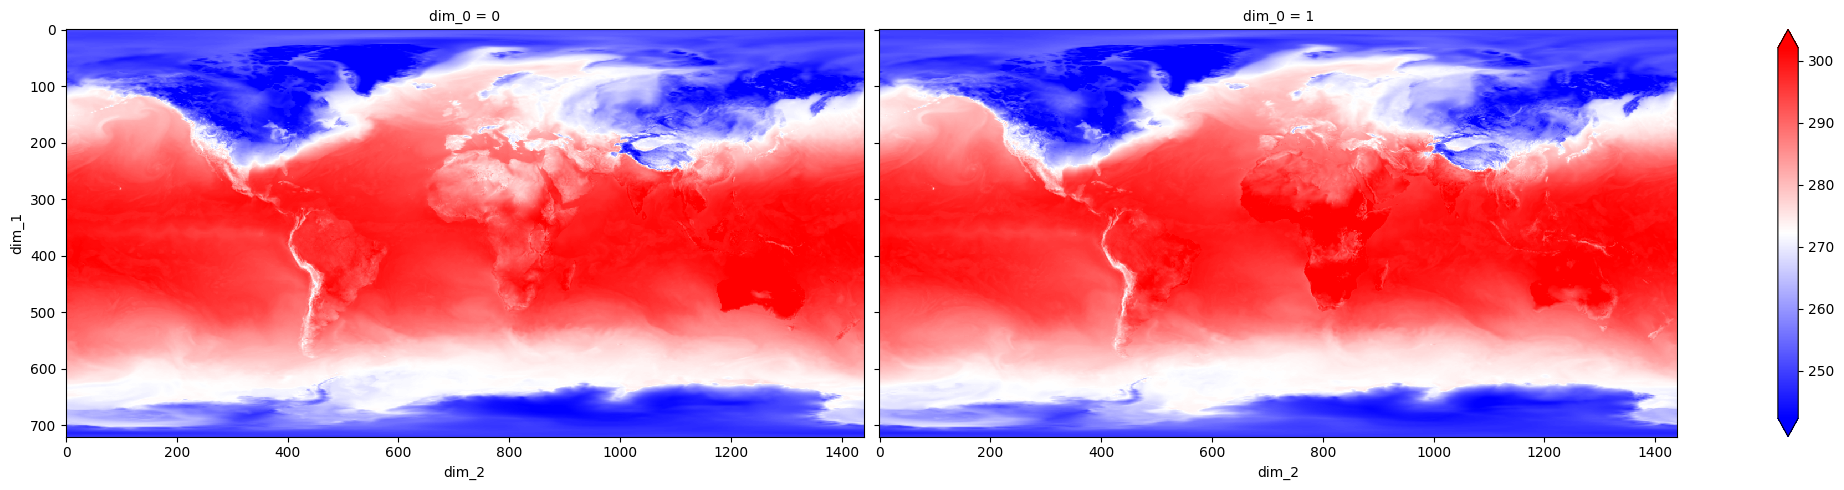

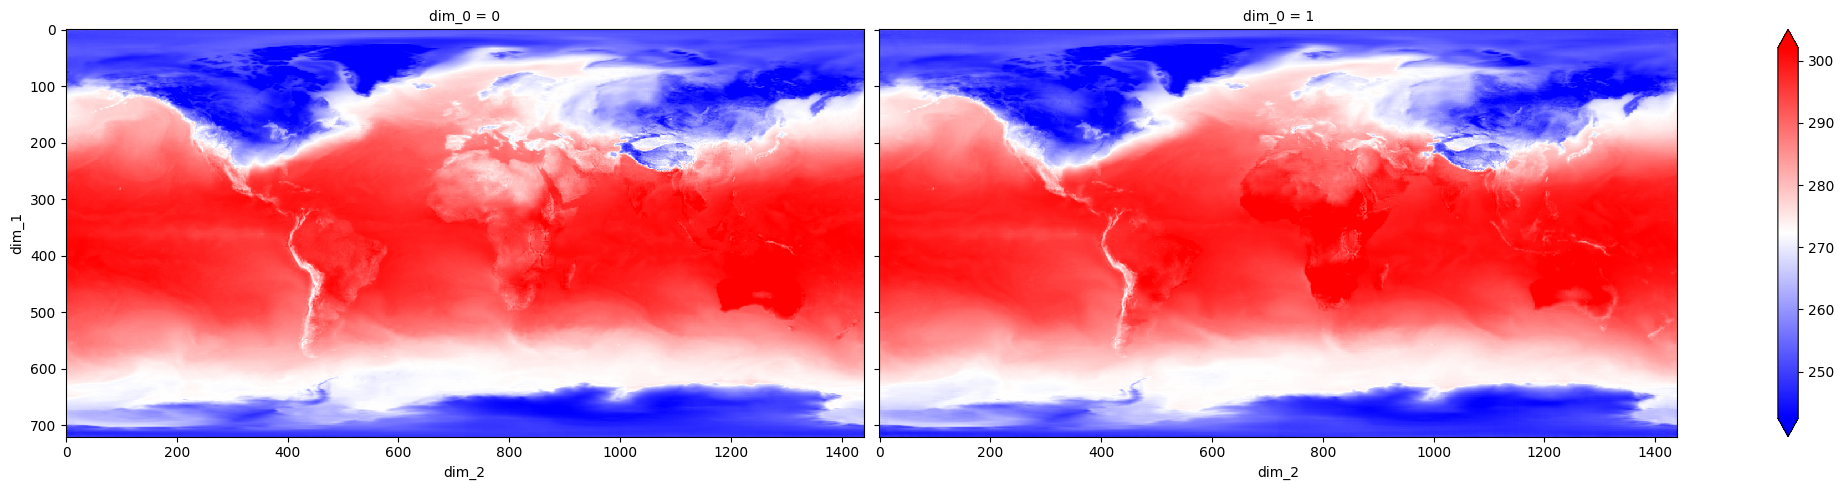

In [3]:
import zarr
with zarr.open('/tmp/pred.zarr') as pred_ds:
    print('time steps:', pred_ds['time'][:])
    pred = pred_ds['2t'][:]

gt_file = '/g/data/rt52/era5/single-levels/reanalysis/2t/2018/2t_era5_oper_sfc_20180101-20180131.nc'
with xr.open_dataset(gt_file) as gt_ds:
    gt_ds = gt_ds.sel(time=pred_ds['time'], method='nearest')
    var_name = list(gt_ds.keys())[0]
    ground_truth = gt_ds[var_name].values

xr.DataArray(ground_truth).plot.imshow(robust=True, col='dim_0', origin='upper', size=5, aspect=2, cmap='bwr')
xr.DataArray(pred).plot.imshow(robust=True, col='dim_0', origin='upper', size=5, aspect=2, cmap='bwr')